# Fake News Detection using ML Techniques using single Vectorizer

# Best Result with Random Forest - 41.59% accuracy : 6 way
# Best Result with Random Forest - 72.5% accuracy : Binary


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing the required libraries and setting up the spacy pipeline for lemmatization only support

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#from textblob import TextBlob,Word
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import string
print(string.punctuation)
import spacy
nlp = spacy.load('en', disable=['ner', 'parser'])



[nltk_data] Downloading package punkt to /home/raj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
root_path = './'

## Preparing the data

Following steps are perforemd while preparing the data


1.   Downloading the data and loading the data in pandas dataframe
2.   Identification of missing values and replacing numerical values with median and the text values with NA
3.   Adding the combined column by using the context, statement and justification column.
4.   Splitting and Encoding the subject column as one-hot vectors
5.   Pre-processing the combined columns to remove punctuations, unwanted space and newline characters.
6.  Preparing the binary class label
7.  Fitting the tfidf vector on the train set combined column.
8.  Transforming the train, valid and test data combined column from the tfidf vectorizer fitted on the train set.
9.  Combining the tfidf vectorizer features and the relevant columns of original dataframe and saving the train,test and valid set in feather format
10. Hyper-Parameter tuning of Logistic Regression and evaluation on the test set
11. Hyper-Parameter tuning of Random Forest and evaluation on the test set



### Import  Data

In [5]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv

--2019-08-10 00:50:49--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6969628 (6.6M) [text/plain]
Saving to: ‘train2.tsv’

train2.tsv          100%[===================>]   6.65M  5.26MB/s    in 1.3s    

2019-08-10 00:50:51 (5.26 MB/s) - ‘train2.tsv’ saved [6969628/6969628]



In [6]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv

--2019-08-10 00:50:51--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 863858 (844K) [text/plain]
Saving to: ‘val2.tsv’

val2.tsv            100%[===================>] 843.61K  1.19MB/s    in 0.7s    

2019-08-10 00:50:53 (1.19 MB/s) - ‘val2.tsv’ saved [863858/863858]



In [7]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv

--2019-08-10 00:50:53--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.192.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 869788 (849K) [text/plain]
Saving to: ‘test2.tsv’

test2.tsv           100%[===================>] 849.40K  1.06MB/s    in 0.8s    

2019-08-10 00:50:55 (1.06 MB/s) - ‘test2.tsv’ saved [869788/869788]



In [0]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/forbidden_words.txt

In [0]:
with open("forbidden_words.txt") as f: # Print forbidden words
  print(f.read())

In [4]:
df_train = pd.read_csv("train2.tsv", sep="\t", header=None)

In [5]:
df_valid = pd.read_csv("val2.tsv", sep="\t", header=None)

In [6]:
df_test = pd.read_csv("test2.tsv", sep="\t", header=None)

In [7]:
df_train[3].values[:1]

array(['Says the Annies List political group supports third-trimester abortions on demand.'],
      dtype=object)

In [8]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


### Fill Missing Values

In [9]:
df_cols = ['label', 'statement', 'subject', 'speaker', 'speaker_job', 'state', 'party_affiliation', 
           'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context', 'justification']
# col 8 - 12 are historical counts for person

In [10]:
df_train = df_train.drop(columns=[0, 1]) ; df_train.columns = df_cols

In [11]:
df_valid = df_valid.drop(columns=[0, 1]) ; df_valid.columns = df_cols

In [12]:
df_test = df_test.drop(columns=[0, 1]) ; df_test.columns = df_cols

In [13]:
df_train['subject'].fillna("NA", inplace = True)
df_valid['subject'].fillna("NA", inplace = True)
df_test['subject'].fillna("NA", inplace = True)

df_train['speaker'].fillna("NA", inplace = True)
df_valid['speaker'].fillna("NA", inplace = True)
df_test['speaker'].fillna("NA", inplace = True)

df_train['speaker_job'].fillna("NA", inplace = True)
df_valid['speaker_job'].fillna("NA", inplace = True)
df_test['speaker_job'].fillna("NA", inplace = True)

df_train['party_affiliation'].fillna("NA", inplace = True)
df_valid['party_affiliation'].fillna("NA", inplace = True)
df_test['party_affiliation'].fillna("NA", inplace = True)

df_train['context'].fillna("NA", inplace = True)
df_valid['context'].fillna("NA", inplace = True)
df_test['context'].fillna("NA", inplace = True)

df_train['state'].fillna("NA", inplace = True)
df_valid['state'].fillna("NA", inplace = True)
df_test['state'].fillna("NA", inplace = True)


df_train['justification'].fillna("NA", inplace = True)
df_valid['justification'].fillna("NA", inplace = True)
df_test['justification'].fillna("NA", inplace = True)

df_train['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_valid['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_test['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)


df_train['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_valid['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_test['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)


df_train['false'].fillna(df_train['false'].median(), inplace = True)
df_valid['false'].fillna(df_train['false'].median(), inplace = True)
df_test['false'].fillna(df_train['false'].median(), inplace = True)

df_train['half_true'].fillna(df_train['half_true'].median(), inplace = True)
df_valid['half_true'].fillna(df_train['half_true'].median(), inplace = True)
df_test['half_true'].fillna(df_train['half_true'].median(), inplace = True)

df_train['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)
df_valid['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)
df_test['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)

df_train['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)
df_valid['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)
df_test['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)





In [0]:
df_train[:3]

In [0]:
len(df_train) - df_train.count()

In [0]:
len(df_valid) - df_valid.count()

In [0]:
len(df_test) - df_test.count()

# Creating the combined column

In [14]:
df_train['combined'] = df_train['context'] + ' '+ df_train['statement'] + ' ' + df_train['justification']
df_valid['combined'] = df_valid['context'] + ' '+ df_valid['statement'] + ' ' + df_valid['justification']
df_test['combined'] = df_test['context'] + ' '+ df_test['statement'] + ' ' + df_test['justification']

# Splitting the subject column and one-hot encoding

In [15]:
l = list(df_train.subject.str.split(','))

In [16]:
s = set()
for i in l:
    for j in i:
        if j not in s:
            s.add(j)
len(list(s))

143

In [17]:
for sub in (list(s)):
    df_train[f'sub_{sub}'] = [1 if sub in x.split(',') else 0 for x in df_train['subject']]
    df_valid[f'sub_{sub}'] = [1 if sub in x.split(',') else 0 for x in df_valid['subject']]
    df_test[f'sub_{sub}'] = [1 if sub in x.split(',') else 0 for x in df_test['subject']]

In [17]:
df_test[:1]

,label,statement,subject,speaker,speaker_job,state,party_affiliation,barely_true,false,half_true,...,sub_public-health,sub_redistricting,sub_bankruptcy,sub_energy,sub_county-budget,sub_foreign-policy,sub_trade,sub_transportation,sub_women,sub_privacy
0,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,...,0,0,0,0,0,0,0,0,0,0


# Preparing the binary label

In [18]:
df_train['label_binaray'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_train['label']] 
df_valid['label_binaray'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_valid['label']] 
df_test['label_binaray'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_test['label']] 

In [19]:
df_train.groupby(['label_binaray'])['label'].count()

label_binaray
False    4488
True     5752
Name: label, dtype: int64

#### Preprocessing and fitting the tfidf vectorizer

In [20]:
def preprocess_text(df,colname):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df[colname] = df[colname].fillna(' ')
    df[colname] = df[colname].str.replace('\n',' ')
    df[colname] = df[colname].str.replace('\r',' ')
    return df

In [21]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train,'combined')
df_valid = preprocess_text(df_valid,'combined')
df_test = preprocess_text(df_test,'combined')

In [22]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)   # removing punctuations
    doc = nlp(text) 
    text = ' '.join([str(token.lemma_) for token in doc]) # lemmatization using spaCy
    tokens = word_tokenize(text) # tokenization using nltk
    return tokens

In [23]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenize', 'sentence', 'have', 'star']

In [24]:
tfidfVectorizer = f'{root_path}tfidfVectorizer_'
tfidfVectorizer_pos = f'{root_path}tfidfVectorizer_pos_'
tfidfVectorizer_neg = f'{root_path}tfidfVectorizer_neg_'

import joblib
# joblib.dump(vect, f'{tfidfVectorizer}3000.pkl')

# Creating parallel threads for faster learning

In [25]:
from multiprocessing import Process
from scipy import sparse

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [29]:
vect = TfidfVectorizer(lowercase = True, max_features = 6000,ngram_range=(1, 3), 
                           tokenizer = tokenizer_better,stop_words = 'english')
stop = list(vect.get_stop_words())+['-PRON-','make','pron']

In [30]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
vect = None
if (os.path.exists(f'{tfidfVectorizer}3000.pkl')):
  vect = joblib.load(f'{tfidfVectorizer}3000.pkl')
else:
  vect = TfidfVectorizer(lowercase = True, max_features = 6000,ngram_range=(1, 3), 
                           tokenizer = tokenizer_better,stop_words = stop)
  print('Fitting vectorizer')
  vect.fit(df_train['combined'].values)
  joblib.dump(vect, f'{tfidfVectorizer}3000.pkl')
    

In [31]:
def train_pos():
    from scipy import sparse
    X_train_tf = vect.transform(df_train['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer}3000_train.npz', X_train_tf)
        
    y_train_binary = df_train['label_binaray']
    y_train =  df_train['label']
    np.save('y_train.npy', y_train)
    np.save('y_train_binary.npy', y_train_binary)


In [32]:
def valid_pos():
    from scipy import sparse
    X_valid_tf = vect.transform(df_valid['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer}3000_valid.npz', X_valid_tf)
    
    y_valid_binary = df_valid['label_binaray']
    y_valid =  df_valid['label']
    np.save('y_valid.npy', y_valid)
    np.save('y_valid_binary.npy', y_valid_binary)


In [33]:
def test_pos():
    from scipy import sparse
    X_test_tf = vect.transform(df_test['combined'].values)
    sparse.save_npz(f'{tfidfVectorizer}3000_test.npz', X_test_tf)
    
    y_test_binary = df_test['label_binaray']
    y_test =  df_test['label']
    np.save('y_test.npy', y_test)
    np.save('y_test_binary.npy', y_test_binary)


In [42]:
p1 = Process(target=train_pos)
p1.start()
p3 = Process(target=valid_pos)
p3.start()
p5 = Process(target=test_pos)
p5.start()
print("here")
p1.join()
p3.join()
print("here")
p5.join()
print("here")

here
here
here


In [34]:
X_train_tf_pos = None

X_valid_tf_pos = None

X_test_tf_pos = None

y_train = None
y_valid = None
y_train_binary = None
y_valid_binary = None
y_test = None
y_test_binary = None


from scipy import sparse

if(os.path.exists(f'{tfidfVectorizer}3000_train.npz')):   
    X_train_tf_pos = sparse.load_npz(f'{tfidfVectorizer}3000_train.npz')

    y_train = np.load(f'{root_path}y_train.npy',allow_pickle=True)
    y_train_binary = np.load(f'{root_path}y_train_binary.npy',allow_pickle=True)
    
        
    
if (os.path.exists(f'{tfidfVectorizer}3000_valid.npz')):  
    X_valid_tf_pos = sparse.load_npz(f'{tfidfVectorizer}3000_valid.npz')
    
    y_valid = np.load(f'{root_path}y_valid.npy',allow_pickle=True)    
    y_valid_binary = np.load(f'{root_path}y_valid_binary.npy',allow_pickle=True)
    
if (os.path.exists(f'{tfidfVectorizer}3000_test.npz')):  
    X_test_tf_pos = sparse.load_npz(f'{tfidfVectorizer}3000_test.npz')
    
    y_test = np.load(f'{root_path}y_test.npy',allow_pickle=True)    
    y_test_binary = np.load(f'{root_path}y_test_binary.npy',allow_pickle=True)
    
    


# Combining the relevant columns

In [35]:
df_train_temp_pos = pd.DataFrame(X_train_tf_pos.toarray(),columns=vect.get_feature_names())

df_valid_temp_pos = pd.DataFrame(X_valid_tf_pos.toarray(),columns=vect.get_feature_names())

df_test_temp_pos = pd.DataFrame(X_test_tf_pos.toarray(),columns=vect.get_feature_names())


In [36]:
final_cols = []
for i in df_train.columns:
    if i not in ['label','statement','subject','context','justification','combined','label_binaray']:
        final_cols.append(i)

In [37]:
final_cols

['speaker',
 'speaker_job',
 'state',
 'party_affiliation',
 'barely_true',
 'false',
 'half_true',
 'mostly_true',
 'pants_on_fire',
 'sub_deficit',
 'sub_islam',
 'sub_social-security',
 'sub_autism',
 'sub_criminal-justice',
 'sub_crime',
 'sub_housing',
 'sub_gambling',
 'sub_oil-spill',
 'sub_debates',
 'sub_animals',
 'sub_florida',
 'sub_job-accomplishments',
 'sub_baseball',
 'sub_candidates-biography',
 'sub_government-efficiency',
 'sub_wealth',
 'sub_fake-news',
 'sub_lottery',
 'sub_civil-rights',
 'sub_city-budget',
 'sub_diversity',
 'sub_public-health',
 'sub_public-service',
 'sub_pop-culture',
 'sub_county-budget',
 'sub_public-safety',
 'sub_infrastructure',
 'sub_congressional-rules',
 'sub_federal-budget',
 'sub_obama-birth-certificate',
 'sub_agriculture',
 'sub_space',
 'sub_ebola',
 'sub_market-regulation',
 'sub_campaign-advertising',
 'sub_campaign-finance',
 'sub_pensions',
 'sub_supreme-court',
 'sub_sports',
 'sub_census',
 'sub_ethics',
 'sub_drugs',
 'sub_

In [38]:
df_train_temp = df_train[final_cols].copy()
df_valid_temp = df_valid[final_cols].copy()
df_test_temp = df_test[final_cols].copy()

In [39]:
df_train_final = pd.concat([df_train_temp_pos,df_train_temp], ignore_index=False, sort=False,axis=1)
df_valid_final = pd.concat([df_valid_temp_pos,df_valid_temp], ignore_index=False, sort=False,axis=1)
df_test_final = pd.concat([df_test_temp_pos,df_test_temp], ignore_index=False, sort=False,axis=1)

In [40]:
df_train_final.drop(columns=['speaker','state'],inplace=True)
df_valid_final.drop(columns=['speaker','state'],inplace=True)
df_test_final.drop(columns=['speaker','state'],inplace=True)


# Conversion to categorical variables and downtyping the columns for spatial efficiency

In [41]:
df_train_final['speaker'] = df_train['speaker'].astype('category')
df_valid_final['speaker'] = df_valid['speaker']
df_test_final['speaker'] = df_test['speaker']

df_train_final['state'] = df_train['state'].astype('category')
df_valid_final['state'] = df_valid['state']
df_test_final['state'] = df_test['state']


In [42]:
df_train_final[final_cols].head()

,speaker,speaker_job,state,party_affiliation,barely_true,false,false,half_true,mostly_true,pants_on_fire,...,sub_consumer-safety,sub_afghanistan,sub_congress,sub_abc-news-week,sub_state-finances,sub_legal-issues,sub_new-hampshire-2012,sub_gas-prices,sub_message-machine,sub_voting-record
0,dwayne-bohac,State representative,Texas,republican,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,barack-obama,President,Illinois,democrat,70.0,0.0,71.0,160.0,163.0,9.0,...,0,0,0,0,0,0,0,0,0,0
3,blog-posting,NA,NA,none,7.0,0.0,19.0,3.0,5.0,44.0,...,0,0,0,0,0,0,0,0,0,0
4,charlie-crist,NA,Florida,democrat,15.0,0.0,9.0,20.0,19.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
zz = ['party_affiliation',  'speaker_job']
for col in zz:
    print(col)
    df_train_final[col] = df_train_final[col].astype('category')
    #df_train_final[col] = df_train_final[col].apply(lambda x: x.cat.codes)
    
#     df_valid_final[col] = df_valid_final[col].astype('category')
#     #df_train_final[col] = df_train_final[col].apply(lambda x: x.cat.codes)
    
#     df_test_final[col] = df_test_final[col].astype('category')
#     #df_test_final[col] = df_test_final[col].apply(lambda x: x.cat.codes)

party_affiliation
speaker_job


In [44]:
# From FastAI
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
        """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtypes.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)


In [45]:
apply_cats(df_valid_final,df_train_final)

In [46]:
apply_cats(df_test_final,df_train_final)

In [47]:
final_cols[4:9]
for col in final_cols[4:9]:
  df_train_final[col] = df_train[col].astype(np.int16)

  df_valid_final[col] = df_valid[col].astype(np.int16)

  df_test_final[col] = df_test[col].astype(np.int16)
  

In [48]:
for col in final_cols[9:]:
  df_train_final[col] = df_train_final[col].astype(np.bool)

  df_valid_final[col] = df_valid_final[col].astype(np.bool)

  df_test_final[col] = df_test_final[col].astype(np.bool)
  

In [49]:
df_train_final.shape

(10240, 6150)

In [50]:
df_valid_final.shape

(1284, 6150)

In [51]:
df_test_final.shape

(1267, 6150)

# Removing duplicate columns created by the tfidf_pos and tfidf_neg vector and saving files to feather format for ease for quick reading from the disk

In [52]:
cat_columns = df_train_final.select_dtypes(['category']).columns
df_train_final[cat_columns] = df_train_final[cat_columns].apply(lambda x: x.cat.codes)

df_valid_final[cat_columns] = df_valid_final[cat_columns].apply(lambda x: x.cat.codes)

df_test_final[cat_columns] = df_test_final[cat_columns].apply(lambda x: x.cat.codes)

In [53]:
trial = df_train_final.loc[:,~df_train_final.columns.duplicated()]

In [54]:
trial.shape

(10240, 6149)

In [55]:
trial.to_feather(f'{root_path}train')

In [56]:
trial = df_valid_final.loc[:,~df_valid_final.columns.duplicated()]

In [57]:
trial.shape

(1284, 6149)

In [58]:
trial.to_feather(f'{root_path}valid')

In [59]:
trial = df_test_final.loc[:,~df_test_final.columns.duplicated()]

In [60]:
trial.shape

(1267, 6149)

In [61]:
trial.to_feather(f'{root_path}test')

In [5]:
import feather

# Hyperparameter tuning and reporting results

In [6]:
df_train = feather.read_dataframe(f'{root_path}train')
df_valid = feather.read_dataframe(f'{root_path}valid')
df_test = feather.read_dataframe(f'{root_path}test')


y_train = np.load(f'{root_path}y_train.npy',allow_pickle=True)
y_train_binary = np.load(f'{root_path}y_train_binary.npy',allow_pickle=True)

y_valid = np.load(f'{root_path}y_valid.npy',allow_pickle=True)    
y_valid_binary = np.load(f'{root_path}y_valid_binary.npy',allow_pickle=True)


y_test = np.load(f'{root_path}y_test.npy',allow_pickle=True)    
y_test_binary = np.load(f'{root_path}y_test_binary.npy',allow_pickle=True)
    
    

In [7]:
def calc_accuracy(y_actual, y_pred, thresh=0.5):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1.0))+sum((y_pred < thresh) & (y_actual == 0.0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh=0.5):
    # calculates the recall
    if sum(y_actual)==0.0:
        return 0.0
    return sum((y_pred > thresh) & (y_actual == 1.0)) /(sum(y_actual))

def calc_precision(y_actual, y_pred, thresh=0.5):
    # calculates the precision
    if sum(y_pred > thresh)==0:
        return 0.0
    return sum((y_pred > thresh) & (y_actual == 1.0)) /(sum(y_pred > thresh))

def calc_specificity(y_actual, y_pred, thresh=0.5):
    # calculates specificity
    if sum(y_actual ==0)==0.0:
        return 0.0
    return sum((y_pred < thresh) & (y_actual == 0.0)) /(sum(y_actual ==0.0))

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1.0)) /len(y_actual)
  
def calc_f1(y_actual, y_pred, thresh=0.5):
    # calculates the recall
    precision = calc_precision(y_actual, y_pred, thresh)
    #print('precsion',precision)
    recall = calc_recall(y_actual, y_pred, thresh)
    #print('recall',recall)
    if precision + recall ==0.0:
      return 0.0
    f1 = float(2*precision*recall)/float(precision+recall)
    return f1


In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def print_metrics(y_actual_first, y_pred_first, name_first='Valid',thresh=0.5):#, y_actual_second, y_pred_second, name_second):
  fpr_first, tpr_first, thresholds_first = roc_curve(y_actual_first, y_pred_first)
  #fpr_second, tpr_second, thresholds_second = roc_curve(y_actual_second, y_pred_second)


  
  auc_first = roc_auc_score(y_actual_first, y_pred_first)
  #auc_second = roc_auc_score(y_actual_second, y_pred_second)
  
  print(name_first, 'AUC:%.3f'%auc_first)
  #print(name_second, 'AUC:%.3f'%auc_second)

  print(name_first, 'accuracy:%.3f'%calc_accuracy(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'accuracy:%.3f'%calc_accuracy(y_actual_second, y_pred_second, thresh))

  print(name_first, 'recall:%.3f'%calc_recall(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'recall:%.3f'%calc_recall(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'precision:%.3f'%calc_precision(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'precision:%.3f'%calc_precision(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'F1:%.3f'%calc_f1(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'precision:%.3f'%calc_precision(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'specificity:%.3f'%calc_specificity(y_actual_first, y_pred_first, thresh))
  #print(name_second, 'specificity:%.3f'%calc_specificity(y_actual_second, y_pred_second, thresh))
  
  print(name_first, 'prevalence:%.3f'%calc_prevalence(y_actual_first))
  #print(name_second, 'prevalence:%.3f'%calc_prevalence(y_actual_second))
  
  
  plt.plot(fpr_first, tpr_first,'r-', label = name_first + ' AUC: %.2f'%auc_first)
  #plt.plot(fpr_second, tpr_second,'b-',label = name_second + ' AUC: %.2f'%auc_second)
  plt.plot([0,1],[0,1],'-k')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [67]:
df_train.shape

(10240, 6149)

In [68]:
n_jobs=-1

# Logistic Regression Hyper Parameter Tuning and evaluation


 C: 0.002
valid AUC:0.658
valid accuracy:0.607
valid recall:0.525
valid precision:0.651
valid F1:0.582
valid specificity:0.695
valid prevalence:0.520
valid AUC:0.655
valid accuracy:0.618
valid recall:0.666
valid precision:0.625
valid F1:0.645
valid specificity:0.567
valid prevalence:0.520


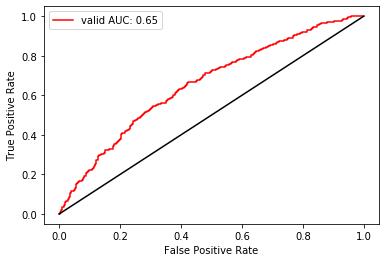


 C: 0.005
valid AUC:0.675
valid accuracy:0.632
valid recall:0.750
valid precision:0.622
valid F1:0.680
valid specificity:0.505
valid prevalence:0.520


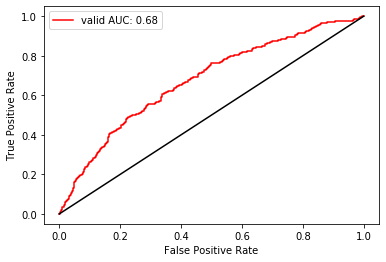


 C: 0.01
valid AUC:0.660
valid accuracy:0.612
valid recall:0.488
valid precision:0.676
valid F1:0.567
valid specificity:0.747
valid prevalence:0.520


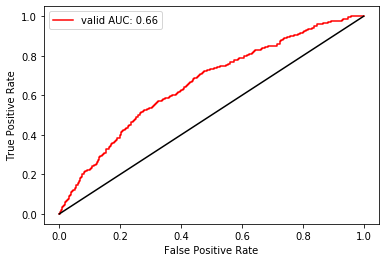


 C: 0.02
valid AUC:0.659
valid accuracy:0.611
valid recall:0.513
valid precision:0.662
valid F1:0.578
valid specificity:0.716
valid prevalence:0.520


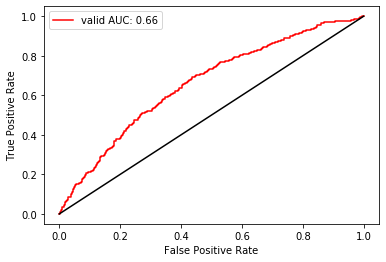


 C: 0.03
valid AUC:0.656
valid accuracy:0.607
valid recall:0.708
valid precision:0.605
valid F1:0.652
valid specificity:0.498
valid prevalence:0.520


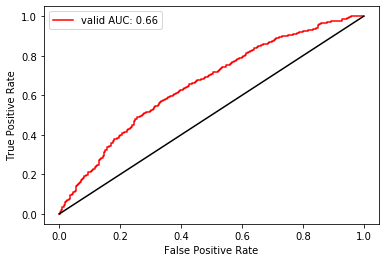


 C: 0.05
valid AUC:0.644
valid accuracy:0.589
valid recall:0.828
valid precision:0.572
valid F1:0.677
valid specificity:0.330
valid prevalence:0.520


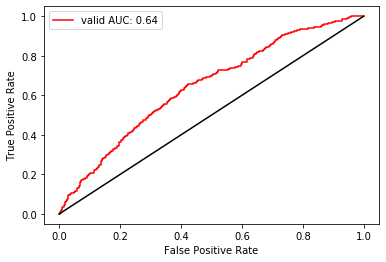


 C: 0.1
valid AUC:0.664
valid accuracy:0.618
valid recall:0.522
valid precision:0.670
valid F1:0.587
valid specificity:0.721
valid prevalence:0.520


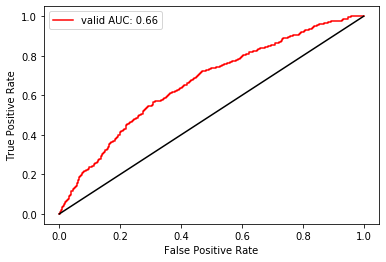


 C: 0.2
valid AUC:0.668
valid accuracy:0.616
valid recall:0.671
valid precision:0.621
valid F1:0.645
valid specificity:0.557
valid prevalence:0.520


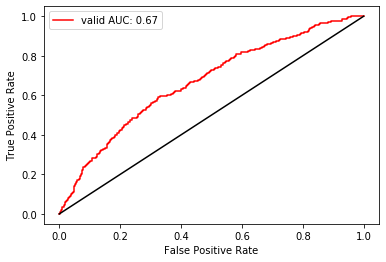


 C: 0.5
valid AUC:0.658
valid accuracy:0.616
valid recall:0.639
valid precision:0.629
valid F1:0.634
valid specificity:0.591
valid prevalence:0.520


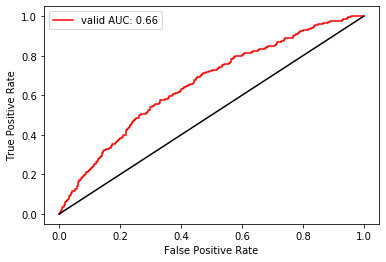


 C: 1.0
valid AUC:0.654
valid accuracy:0.603
valid recall:0.850
valid precision:0.581
valid F1:0.690
valid specificity:0.334
valid prevalence:0.520


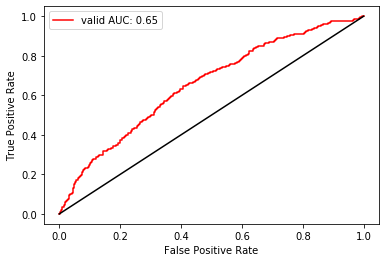

In [72]:
from sklearn.linear_model import LogisticRegression

Cs = [0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.5,1.0]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

train_acc = np.zeros(len(Cs))
valid_acc = np.zeros(len(Cs))

train_precision = np.zeros(len(Cs))
valid_precision = np.zeros(len(Cs))

train_recall = np.zeros(len(Cs))
valid_recall = np.zeros(len(Cs))

train_f1 = np.zeros(len(Cs))
valid_f1 = np.zeros(len(Cs))

train_spec = np.zeros(len(Cs))
valid_spec = np.zeros(len(Cs))


for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', solver='lbfgs', random_state = 42,max_iter=150,n_jobs=n_jobs)
    clf.fit(df_train, y_train_binary)

    model = clf
    y_train_preds = model.predict_proba(df_train)[:,1]
    y_valid_preds = model.predict_proba(df_valid)[:,1]

    auc_train = roc_auc_score(y_train_binary, y_train_preds)
    auc_valid = roc_auc_score(y_valid_binary, y_valid_preds)
    
    print_metrics(y_valid_binary, y_valid_preds, name_first='valid',thresh = 0.5)
    
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid
    
    train_acc[ii] = calc_accuracy(y_train_binary, y_train_preds)
    valid_acc[ii] = calc_accuracy(y_valid_binary, y_valid_preds)
    
    train_precision[ii] = calc_precision(y_train_binary, y_train_preds)
    valid_precision[ii] = calc_precision(y_valid_binary, y_valid_preds)
    
    train_recall[ii] = calc_recall(y_train_binary, y_train_preds)
    valid_recall[ii] = calc_recall(y_valid_binary, y_valid_preds)
    
    train_f1[ii] = calc_f1(y_train_binary, y_train_preds)
    valid_f1[ii] = calc_f1(y_valid_binary, y_valid_preds)
    
    train_spec[ii] = calc_specificity(y_train_binary, y_train_preds)
    valid_spec[ii] = calc_specificity(y_valid_binary, y_valid_preds)
    
    

In [73]:
lr_results=pd.DataFrame({'C':Cs,'valid-auc':valid_aucs,'valid-acc':valid_acc,'valid-precision':valid_precision,'valid-recall':valid_recall,'valid_f1':valid_f1})

In [76]:
lr_results

,C,valid-auc,valid-acc,valid-precision,valid-recall,valid_f1
0,0.002,0.657963,0.606698,0.651206,0.525449,0.581607
1,0.003,0.654751,0.618380,0.625000,0.666168,0.644928
2,0.005,0.675176,0.632399,0.621588,0.750000,0.679783
3,0.010,0.659599,0.612150,0.676349,0.488024,0.566957
4,0.020,0.659191,0.610592,0.662162,0.513473,0.578415
5,0.030,0.656204,0.607477,0.604859,0.708084,0.652414
6,0.050,0.644315,0.588785,0.572464,0.827844,0.676867
7,0.100,0.663502,0.617601,0.669866,0.522455,0.587048
8,0.200,0.667869,0.616044,0.621359,0.670659,0.645068
9,0.500,0.658308,0.616044,0.628866,0.639222,0.634001


In [ ]:
clf=LogisticRegression(C = 0.005"""Cs[np.argmax(valid_acc)]""", penalty = 'l2', solver='lbfgs', random_state = 42,max_iter=150,n_jobs=n_jobs)
clf.fit(df_train, y_train_binary)

model = clf
y_train_preds = model.predict_proba(df_train)[:,1]
y_test_preds = model.predict_proba(df_test)[:,1]

print_metrics(y_test_binary, y_test_preds, name_first='test',thresh = 0.5)


test AUC:0.653
test accuracy:0.611
test recall:0.718
test precision:0.637
test F1:0.675
test specificity:0.472
test prevalence:0.564


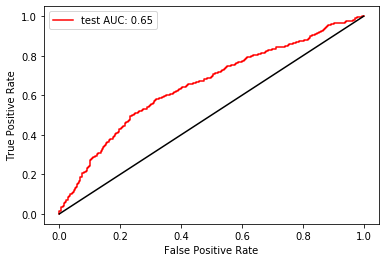

In [75]:
print_metrics(y_test_binary, y_test_preds, name_first='test',thresh = 0.5)


In [52]:
clf1 = LogisticRegression(C=50. / len(df_train),
                         multi_class='multinomial',
                         penalty='l2', solver='saga',n_jobs=-1,max_iter=150)
clf1.fit(df_train, y_train)

/usr/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0048828125, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=150,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

In [54]:
score = clf1.score(df_valid, y_valid)
score

0.29127725856697817

In [55]:
score = clf1.score(df_test, y_test)
score

0.26361483820047354

In [78]:
y_test_preds = clf1.predict(df_test)

In [80]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_preds, target_names=pd.DataFrame({'target':y_test})['target'].unique()))

              precision    recall  f1-score   support

        true       0.26      0.18      0.22       212
       false       0.23      0.73      0.35       249
   half-true       0.35      0.18      0.24       265
  pants-fire       0.31      0.20      0.24       241
 barely-true       0.49      0.18      0.27        92
 mostly-true       0.00      0.00      0.00       208

   micro avg       0.26      0.26      0.26      1267
   macro avg       0.27      0.25      0.22      1267
weighted avg       0.26      0.26      0.22      1267



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Random Forest Hyper-parameter tuning and evaluation

valid AUC:0.821
valid accuracy:0.717
valid recall:0.862
valid precision:0.679
valid F1:0.760
valid specificity:0.558
valid prevalence:0.520


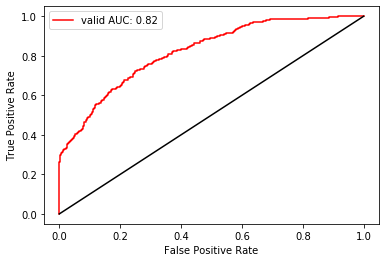

test AUC:0.809
test accuracy:0.727
test recall:0.873
test precision:0.710
test F1:0.783
test specificity:0.539
test prevalence:0.564


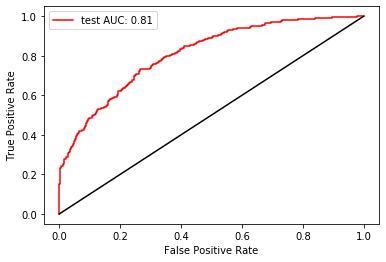

In [15]:
clf = RandomForestClassifier(max_features=0.6,max_depth = 23,min_samples_leaf = 13,min_samples_split = 13,n_estimators = 70 , criterion = 'entropy', random_state = 42,n_jobs=-1)
clf.fit(df_train, y_train_binary)
model=clf
y_train_preds = model.predict_proba(df_train)[:,1]
y_test_preds = model.predict_proba(df_test)[:,1]
y_valid_preds = model.predict_proba(df_valid)[:,1]
print_metrics(y_valid_binary, y_valid_preds, name_first='valid',thresh = 0.5) 
print_metrics(y_test_binary, y_test_preds, name_first='test',thresh = 0.5)

valid AUC:0.819
valid accuracy:0.708
valid recall:0.853
valid precision:0.673
valid F1:0.752
valid specificity:0.550
valid prevalence:0.520


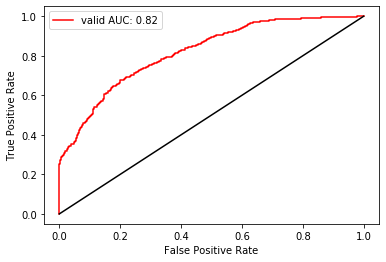

test AUC:0.810
test accuracy:0.725
test recall:0.880
test precision:0.705
test F1:0.783
test specificity:0.524
test prevalence:0.564


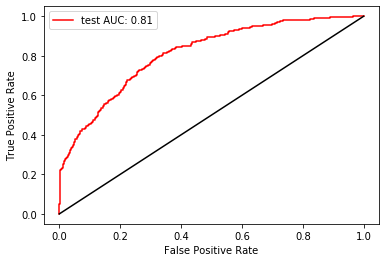

In [87]:
clf = RandomForestClassifier(max_features=0.6,max_depth = 23,min_samples_leaf = 13,min_samples_split = 13,n_estimators = 70 , criterion = 'gini', random_state = 42,n_jobs=-1)
clf.fit(df_train, y_train_binary)
model=clf
y_train_preds = model.predict_proba(df_train)[:,1]
y_test_preds = model.predict_proba(df_test)[:,1]
y_valid_preds = model.predict_proba(df_valid)[:,1]
print_metrics(y_valid_binary, y_valid_preds, name_first='valid',thresh = 0.5) 
print_metrics(y_test_binary, y_test_preds, name_first='test',thresh = 0.5)

In [17]:
clf = RandomForestClassifier(max_features=0.6,max_depth = 23,min_samples_leaf = 13,min_samples_split = 13,n_estimators = 70 , criterion = 'gini', random_state = 42,n_jobs=-1)
clf.fit(df_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=23, max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=13,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [18]:
y_test_pred = clf.predict(df_test)

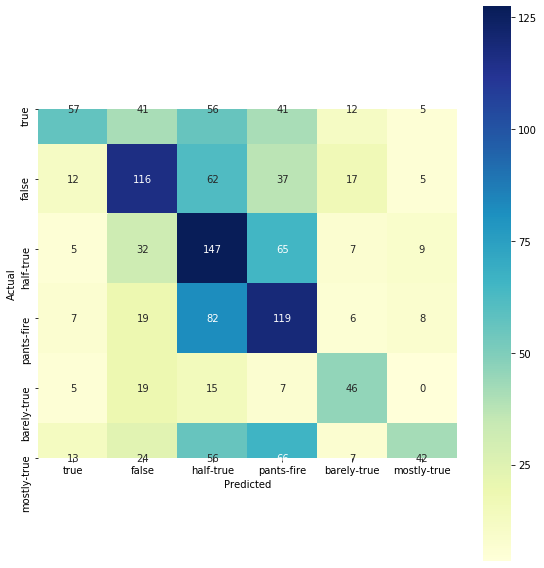

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',square=True,cmap="YlGnBu",robust=True,
            xticklabels=pd.DataFrame({'target':y_test})['target'].unique(), yticklabels=pd.DataFrame({'target':y_test})['target'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('cm_single.png')
plt.show()

In [51]:
score = clf.score(df_test, y_test)
score

0.4159431728492502

In [50]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_pred, target_names=pd.DataFrame({'target':y_test})['target'].unique()))

              precision    recall  f1-score   support

        true       0.58      0.27      0.37       212
       false       0.46      0.47      0.46       249
   half-true       0.35      0.55      0.43       265
  pants-fire       0.36      0.49      0.41       241
 barely-true       0.48      0.50      0.49        92
 mostly-true       0.61      0.20      0.30       208

   micro avg       0.42      0.42      0.42      1267
   macro avg       0.47      0.41      0.41      1267
weighted avg       0.46      0.42      0.41      1267



In [74]:
l = []
for i,feature in enumerate(clf.feature_importances_):
    l.append((df_train.columns[i],feature))

In [75]:
from operator import itemgetter
l.sort( key = lambda x: x[1])

In [76]:
l.reverse()


In [77]:
l[:100]

[('mostly_true', 0.15748638921774724),
 ('barely_true', 0.15069448382699413),
 ('false', 0.13155558175442872),
 ('half_true', 0.12720486736909176),
 ('pants_on_fire', 0.1072074017347963),
 ('say', 0.03644245383514859),
 ('speaker', 0.020153955028225357),
 ('s', 0.019760206053632493),
 ('speaker_job', 0.014731357371784265),
 ('party_affiliation', 0.013282341479401053),
 ('state', 0.012332398527883632),
 ('year', 0.008587447327145227),
 ('percent', 0.007916944913792303),
 ('interview', 0.006403714001362206),
 ('campaign', 0.004234163103859688),
 ('obama', 0.004173722633339087),
 ('ad', 0.003992265992370272),
 ('statement', 0.0032203657804916424),
 ('speech', 0.003114936949444101),
 ('vote', 0.003079296689501714),
 ('number', 0.0030134102375236342),
 ('people', 0.0029616707393217046),
 ('time', 0.002924581963334265),
 ('republican', 0.0027931593511019317),
 ('sub_health-care', 0.0024729513367777165),
 ('support', 0.0023997728029140283),
 ('t', 0.002292167044847377),
 ('use', 0.00216075071